# Nencioli

In [1]:
import pickle
with open('/srv/scratch/z5297792/Sample/U.pkl', 'rb') as file:
    U = pickle.load(file)
with open('/srv/scratch/z5297792/Sample/V.pkl', 'rb') as file:
    V = pickle.load(file)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time


In [2]:
def nenc_crit_1_2(u, v, a):
    rows_v, cols_v = v.shape
    rows_u, cols_u = u.shape
    if rows_v != rows_u or cols_v != cols_u:
        raise ValueError("The shapes of 'v' and 'u' must be the same.")

    criteria_mask_1 = np.zeros_like(v, dtype=bool)
    criteria_mask_2 = np.zeros_like(u, dtype=bool)

    # First function nenc_crit_1
    for j in range(a, cols_v - a):
        wrk = v[:, j]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for ii in indx:
            if ii - a >= 0 and ii + a < rows_v:  # Check boundaries
                if v[ii - a, j] * v[ii + a, j] < 0:
                    if abs(v[ii - a, j]) > abs(v[ii, j]) and abs(v[ii + a, j]) > abs(v[ii, j]):
                        criteria_mask_1[ii, j] = True

    # Second function nenc_crit_2, only checking where criteria_mask_1 is True
    for i in range(a, rows_u - a):
        wrk = u[i, :]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for jj in indx:
            if criteria_mask_1[i, jj]:  # Only check where nenc_crit_1 is True
                if jj - a >= 0 and jj + a < cols_u:  # Check boundaries
                    if u[i, jj - a] * u[i, jj + a] < 0:
                        if abs(u[i, jj - a]) > abs(u[i, jj]) and abs(u[i, jj + a]) > abs(u[i, jj]):
                            criteria_mask_2[i, jj] = True

    return criteria_mask_2

def nenc_crit_3(u, v, b):
    velocity_magnitude = np.sqrt(u**2 + v**2)
    rows, cols = velocity_magnitude.shape
    local_minimum_mask = np.zeros_like(velocity_magnitude, dtype=bool)
    for i in range(b, rows - b):  
        for j in range(b, cols - b):  
            current_magnitude = velocity_magnitude[i, j]
            neighborhood = velocity_magnitude[i-b:i+b+1, j-b:j+b+1]
            if current_magnitude <= np.min(neighborhood):
                local_minimum_mask[i, j] = True
                # Set the 8 neighboring points to True, with boundary checks
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:  # Ensure neighbors are within bounds
                            local_minimum_mask[ni, nj] = True    
    return local_minimum_mask

def nenc_crit_4(u, v, a):

    # Assuming u and v are your 2D matrices of velocities
    rows, cols = u.shape

    # Create a mask to store points that meet the rotational consistency criterion
    rotation_mask = np.zeros_like(u, dtype=bool)

    def is_cyclic_rotation(lst):
        # Define allowed transitions for both patterns
        valid_pairs_1 = {(1, 2), (2, 3), (3, 4), (4, 1),  # Pattern 1: Ascending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        valid_pairs_2 = {(2, 1), (3, 2), (4, 3), (1, 4),  # Pattern 2: Descending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        
        # Helper function to check if the list satisfies a given set of valid pairs
        def check_valid(lst, valid_pairs):
            for i in range(1, len(lst)):
                if (lst[i-1], lst[i]) not in valid_pairs:
                    return False
            return True
    
        # Check both conditions
        check_1 = check_valid(lst, valid_pairs_1)
        check_2 = check_valid(lst, valid_pairs_2)
    
        # Return True if exactly one condition is satisfied
        return (check_1 or check_2) and not (check_1 and check_2)
    
    # Function to determine the quadrant of an angle
    def quadrant_check(u_bound, v_bound):
        u_bound, v_bound = np.array(u_bound), np.array(v_bound)
        quadrants = np.zeros(u_bound.shape, dtype=int)
        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4

        if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
            if is_cyclic_rotation(quadrants):
                return True
        
        return False

    # Function to check if two quadrants are adjacent
    def adjacent_quadrants(q1, q2):
        return abs(q1 - q2) == 1 or abs(q1 - q2) == 3  # Wrap-around (1 and 4 are adjacent)
        
    # Loop through each point (avoid the edges by 'a' grid points)
    for i in range(a, rows - a):
        for j in range(a, cols - a):
  
            u_bound = []
            u_bound.extend(u[i-a:i+a+1,j+a])
            u_bound.extend(np.flip(u[i+a,j-a:j+a+1]))
            u_bound.extend(np.flip(u[i-a:i+a+1,j-a]))
            u_bound.extend(u[i-a,j-a:j+a+1])

            v_bound = []
            v_bound.extend(v[i-a:i+a+1,j+a])
            v_bound.extend(np.flip(v[i+a,j-a:j+a+1]))
            v_bound.extend(np.flip(v[i-a:i+a+1,j-a]))
            v_bound.extend(v[i-a,j-a:j+a+1])
            
            if quadrant_check(u_bound, v_bound):
                rotation_mask[i, j] = True

    return rotation_mask


Text(0.5, 1.0, 'Crit. 4')

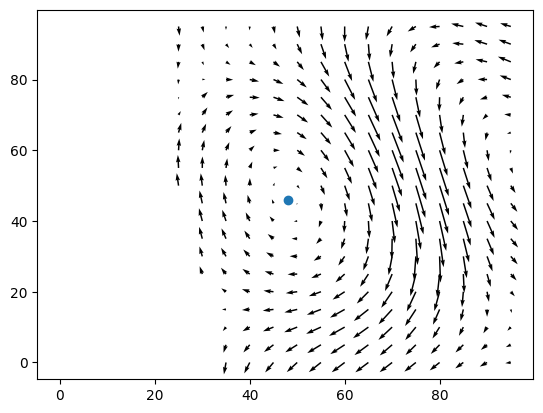

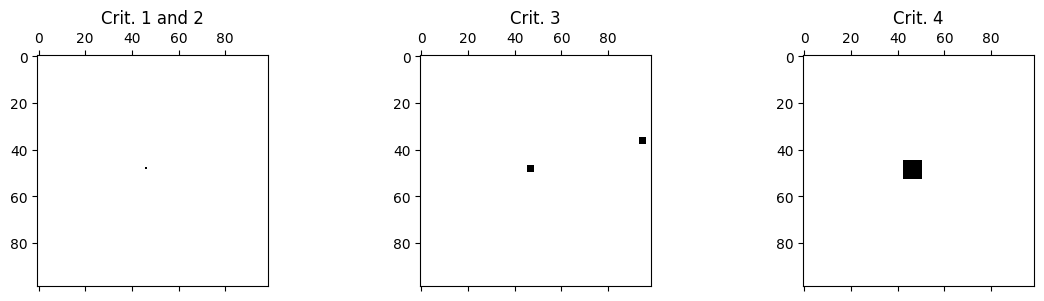

In [3]:
depth_lvl = 15
u, v = U[:,:,depth_lvl], V[:,:,depth_lvl]
a, b = 4, 3
combined = np.logical_and.reduce((nenc_crit_1_2(u, v, a), nenc_crit_3(u, v, b), nenc_crit_4(u, v, a)))
ic, jc = np.where(combined)

x, y = np.arange(0, u.shape[0]), np.arange(0, u.shape[1])

spacing = 5
plt.quiver(x[::spacing], y[::spacing], U[::spacing,::spacing,depth_lvl].T,V[::spacing,::spacing,depth_lvl].T)
plt.scatter(ic, jc)

fig, axs = plt.subplots(1, 3, figsize=(14,3))

axs[0].spy(nenc_crit_1_2(u, v, a))
axs[0].set_title('Crit. 1 and 2')
axs[1].spy(nenc_crit_3(u, v, b))
axs[1].set_title('Crit. 3')
axs[2].spy(nenc_crit_4(u, v, a))
axs[2].set_title('Crit. 4')

In [17]:
def nencioli(u, v, a, b):
    rows_v, cols_v = v.shape
    rows_u, cols_u = u.shape
    if rows_v != rows_u or cols_v != cols_u:
        raise ValueError("The shapes of 'v' and 'u' must be the same.")
    rows, cols = rows_v, cols_v
    borders = max(a, b) + 1
    vel = np.sqrt(u**2 + v**2)
    eddy_uv = [0, 0]
    eddy_uv = np.vstack([eddy_uv, [0, 0]])
    eddy_c = [0, 0]
    eddy_c = np.vstack([eddy_c, [0, 0]])
    eddy = [0, 0, 0]
    eddy = np.vstack([eddy, [0, 0, 0]])
    bound = vel.shape
    for i in range(borders, rows - borders + 1):
        # 1st constraint - v component
        wrk = v[i, :]
        s = np.sign(wrk)
        indx = np.where((np.diff(s) != 0) & (~np.isnan(np.diff(s))))[0]
        indx = indx[(indx >= borders) & (indx < cols - borders)]
        for ii in range(len(indx)):
            if wrk[indx[ii]] >= 0: # CE
                if (wrk[indx[ii] - a] > wrk[indx[ii]]) & (wrk[indx[ii] + 1 + a] < wrk[indx[ii] + 1]):
                    var = -1
                else:
                    var = 0
            elif wrk[indx[ii]] < 0: # AE
                if (wrk[indx[ii] - a] < wrk[indx[ii]]) & (wrk[indx[ii] + 1 + a] > wrk[indx[ii] + 1]):
                    var = 1
                else:
                    var = 0
            # 2nd constraint - u component
            if var == -1: # CE
                if ((u[i - a, indx[ii]] <= 0) & (u[i - a, indx[ii]] <= u[i - 1, indx[ii]]) & \
                     (u[i + a, indx[ii]] >= 0) & (u[i + a, indx[ii]] >= u[i + 1, indx[ii]])) | \
                    ((u[i - a, indx[ii] + 1] <= 0) & (u[i - a, indx[ii] + 1] <= u[i - 1, indx[ii] + 1]) & \
                     (u[i + a, indx[ii] + 1] >= 0) & (u[i + a, indx[ii] + 1] >= u[i + 1, indx[ii] + 1])):
                    var = -1
                    eddy_uv = np.vstack([
                        eddy_uv,
                        [i, indx[ii]],
                        [i, indx[ii] + 1]
                    ])
                else:
                    var = 0
            elif var == 1: # AE
                if ((u[i - a, indx[ii]] >= 0) & (u[i - a, indx[ii]] >= u[i - 1, indx[ii]]) & \
                     (u[i + a, indx[ii]] <= 0) & (u[i + a, indx[ii]] <= u[i + 1, indx[ii]])) | \
                    ((u[i - a, indx[ii] + 1] >= 0) & (u[i - a, indx[ii] + 1] >= u[i - 1, indx[ii] + 1]) & \
                     (u[i + a, indx[ii] + 1] <= 0) & (u[i + a, indx[ii] + 1] <= u[i + 1, indx[ii] + 1])):
                    var = 1
                    eddy_uv = np.vstack([
                        eddy_uv,
                        [i, indx[ii]],
                        [i, indx[ii] + 1]
                    ])
                else:
                    var = 0
            # 3rd constraint - velocity minimum
            if var != 0:
                srch = vel[i - b:i + b + 1, indx[ii] - b:indx[ii] + b + 1]
                if not np.any(np.isnan(srch)):
                    si = np.arange(i - b, i + b + 1)
                    sj = np.arange(indx[ii] - b, indx[ii] + b + 1)
                    min_indices = np.argwhere(srch == np.min(srch))
                    X, Y = min_indices[:, 0], min_indices[:, 1]
                    x_start = int(max((i - b) + (X - 1) - b, 0))
                    x_end = int(min((i - b) + (X - 1) + b, bound[0]))
                    y_start = int(max((indx[ii] - b) + (Y - 1) - b, 0))
                    y_end = int(min((indx[ii] - b) + (Y - 1) + b, bound[1]))
                    srch2 = vel[x_start:x_end + 1, y_start:y_end + 1]
                    if not (np.min(srch2) == np.min(srch)):
                        var = 0
                    else:
                        eddy_c = np.vstack([eddy_c, [si[X[0]], sj[Y[0]]]])
                else:
                    var = 0

            # 4th constraint - vector rotation
            d = a - 1
            if var != 0:
                i1, i2 = si[X[0]], sj[Y[0]]
                
                u_small = u[max(i1 - d, 0):min(i1 + d + 1, bound[0]), 
                            max(i2 - d, 0):min(i2 + d + 1, bound[1])]
                
                v_small = v[max(i1 - d, 0):min(i1 + d + 1, bound[0]), 
                            max(i2 - d, 0):min(i2 + d + 1, bound[1])]
                
                if not np.any(np.isnan(u_small)):

                    u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                    v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                    
                    quadrants = np.zeros_like(u_bound, dtype=int)
                    
                    quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                    quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                    quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                    quadrants[(u_bound >= 0) & (v_bound < 0)] = 4

                        
                    consistent_rotation = True
                    for i in range(len(quadrants) - 1):
                        quadrant1 = quadrants[i]
                        quadrant2 = quadrants[i + 1]
                        
                        # Check for same or adjacent quadrants
                        if abs(quadrant1 - quadrant2) > 1 and not (quadrant1 == 1 and quadrant2 == 4):
                            consistent_rotation = False
                            break

                    if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
                        if consistent_rotation:
                            eddy = np.vstack([eddy, [si[X[0]], sj[Y[0]], var]])

    # Sort eddies for lon and lat
    eddy = eddy[np.argsort(eddy[:, 1])]
    eddy = eddy[np.argsort(eddy[:, 0])]
    # Keep only one value per eddy center
    good = np.where((np.diff(eddy[:, 0]) != 0) | (np.diff(eddy[:, 1]) != 0))[0]
    eddy = np.vstack([eddy[0], eddy[good + 1]])
    # Remove zero row from eddy
    zero_eddy = np.where((eddy[:, 0] == 0) & (eddy[:, 1] == 0) & (eddy[:, 2] == 0))[0]
    eddy = np.delete(eddy, zero_eddy, axis=0)
    # Adjust flags for cyclones/anticyclones for the Southern Hemisphere
    eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    # Same for "eddy_uv" and "eddy_c"
    # Sort eddies for lon and lat
    eddy_uv = eddy_uv[np.argsort(eddy_uv[:, 1])]
    eddy_uv = eddy_uv[np.argsort(eddy_uv[:, 0])]
    # Keep only one value per eddy center
    good_uv = np.where((np.diff(eddy_uv[:, 0]) != 0) | (np.diff(eddy_uv[:, 1]) != 0))[0]
    eddy_uv = np.vstack([eddy_uv[0], eddy_uv[good_uv + 1]])
    # Remove zero row from eddy
    zero_eddy_uv = np.where((eddy_uv[:, 0] == 0) & (eddy_uv[:, 1] == 0))[0]
    eddy_uv = np.delete(eddy_uv, zero_eddy_uv, axis=0)
    # Sort eddies for lon and lat
    eddy_c = eddy_c[np.argsort(eddy_c[:, 1])]
    eddy_c = eddy_c[np.argsort(eddy_c[:, 0])]
    # Keep only one value per eddy center
    good_c = np.where((np.diff(eddy_c[:, 0]) != 0) | (np.diff(eddy_c[:, 1]) != 0))[0]
    eddy_c = np.vstack([eddy_c[0], eddy_c[good_c + 1]])
    # Remove zero row from eddy
    zero_eddy_c = np.where((eddy_c[:, 0] == 0) & (eddy_c[:, 1] == 0))[0]
    eddy_c = np.delete(eddy_c, zero_eddy_c, axis=0)

    return eddy, eddy_uv, eddy_c


[[48 47]]


/scratch/pbs.5938092.kman.restech.unsw.edu.au/ipykernel_3283805/1946413464.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_start = int(max((i - b) + (X - 1) - b, 0))
/scratch/pbs.5938092.kman.restech.unsw.edu.au/ipykernel_3283805/1946413464.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_end = int(min((i - b) + (X - 1) + b, bound[0]))
/scratch/pbs.5938092.kman.restech.unsw.edu.au/ipykernel_3283805/1946413464.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy

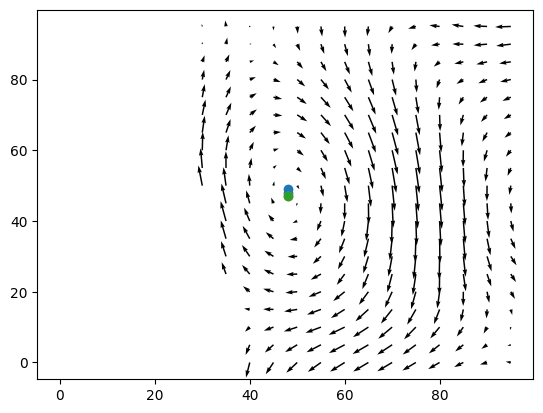

In [39]:
depth_lvl = 22
u, v = U[:,:,depth_lvl], V[:,:,depth_lvl]
a, b = 10, 4

x, y = np.arange(0, u.shape[0]), np.arange(0, u.shape[1])

eddy, eddy_uv, eddy_c = nencioli(u, v, a, b)

print(eddy_c)

spacing = 5
plt.quiver(x[::spacing], y[::spacing], U[::spacing,::spacing,depth_lvl].T,V[::spacing,::spacing,depth_lvl].T)
plt.scatter(eddy_uv[:,0], eddy_uv[:,1])
plt.scatter(eddy_c[:,0], eddy_c[:,1])
plt.scatter(eddy[:,0], eddy[:,1])

In [90]:
def regs_nencioli(u, v, a, b):

    borders = max(a, b) + 1

    eddy_uv = pd.DataFrame({})
    eddy_c = pd.DataFrame({})
    eddy = pd.DataFrame({})

    vel = np.sqrt(u**2 + v**2)

    for i in range(boarders, u.shape[0] - boarders + 1):
        v_row = v[i, :]
        s = np.sign(v_row)
        indx = np.where((np.diff(s) != 0) & (~np.isnan(np.diff(s))))[0]
        indx = indx[(indx >= borders) & (indx < u.shape[1] - boarders)]
        # 1st constraint
        for j in indx:
            if (v_row[j - a] > v_row[j]) & (v_row[j + 1 + a] < v_row[j + 1]):
                var = -1 # CE
            elif (v_row[j - a] < v_row[j]) & (v_row[j + 1 + a] > v_row[j + 1]):
                var = 1 # AE
            else:
                var = 0
            # 2nd constraint
            if var == -1:  # CE
                if ((u[i - a, j] <= 0) & (u[i - a, j] <= u[i - 1, j]) & \
                     (u[i + a, j] >= 0) & (u[i + a, j] >= u[i + 1, j])) | \
                    ((u[i - a, j + 1] <= 0) & (u[i - a, j + 1] <= u[i - 1, j + 1]) & \
                     (u[i + a, j + 1] >= 0) & (u[i + a, j + 1] >= u[i + 1, j + 1])):
                   eddy_uv = pd.concat([eddy_uv, pd.DataFrame({'i': [i, i], 'j': [j, j + 1]})], ignore_index=True)
                else:
                    var = 0
            elif var == 1: # AE
                if ((u[i - a, j] >= 0) & (u[i - a, j] >= u[i - 1, j]) & \
                     (u[i + a, j] <= 0) & (u[i + a, j] <= u[i + 1, j])) | \
                    ((u[i - a, j + 1] >= 0) & (u[i - a, j + 1] >= u[i - 1, j + 1]) & \
                     (u[i + a, j + 1] <= 0) & (u[i + a, j + 1] <= u[i + 1, j + 1])):
                   eddy_uv = pd.concat([eddy_uv, pd.DataFrame({'i': [i, i], 'j': [j, j + 1]})], ignore_index=True)
                else:
                    var = 0
            # 3rd constraint
            if var != 0:
                srch = vel[i - b:i + b + 1, j - b:j + b + 1]
                si = np.arange(i - b, i + b + 1)
                sj = np.arange(j - b, j + b + 1)
                min_indices = np.argwhere(srch == np.min(srch))
                I, J = min_indices[0, 0], min_indices[0, 1]

                x_start = max((i - b) + (I - 1) - b, 0)
                x_end = min((i - b) + (I - 1) + b, u.shape[0])
                y_start = max((j - b) + (J - 1) - b, 0)
                y_end = min((j - b) + (J - 1) + b, u.shape[1])

                srch2 = vel[x_start:x_end + 1, y_start:y_end + 1]
                
                if not (np.min(srch2) == np.min(srch)):
                    var = 0
                else:
                    eddy_c = pd.concat([eddy_c, pd.DataFrame({'i': [si[I]], 'j': [sj[J]]})], ignore_index=True)
            # 4th constraint
            if var != 0:
                d = a -1
                i1, j1 = si[I], sj[J]
                u_small = u[max(i1 - d, 0):min(i1 + d + 1, u.shape[0]), 
                            max(j1 - d, 0):min(j1 + d + 1, u.shape[1])]
                
                v_small = v[max(i1 - d, 0):min(i1 + d + 1, u.shape[0]), 
                            max(j1 - d, 0):min(j1 + d + 1, u.shape[1])]

                if not np.any(np.isnan(u_small)):
                    
                    u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                    v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                    
                    quadrants = np.zeros_like(u_bound, dtype=int)
                    
                    quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                    quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                    quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                    quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
    
                    def is_cyclic_rotation(lst, var):
                        if var ==  1:
                            valid_pairs = {(1, 2), (2, 3), (3, 4), (4, 1),  # Pattern 1: Ascending sequence - Anti-Cyclonic
                                         (1, 1), (2, 2), (3, 3), (4, 4)}  
                        elif var == -1:
                            valid_pairs = {(2, 1), (3, 2), (4, 3), (1, 4),  # Pattern 2: Descending sequence - Cyclonic
                                         (1, 1), (2, 2), (3, 3), (4, 4)}  
                        
                        def check_valid(lst, valid_pairs):
                            for i in range(1, len(lst)):
                                if (lst[i-1], lst[i]) not in valid_pairs:
                                    return False
                            return True
    
                        return check_valid(lst, valid_pairs)
    
                    if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
                        if is_cyclic_rotation(quadrants, var):
                            eddy = pd.concat([eddy, pd.DataFrame({'i': [si[I]], 'j': [sj[J]], 'var': var})], ignore_index=True)
    
    eddy = eddy.sort_values(by=['i', 'j']).reset_index(drop=True)
    eddy = eddy.loc[(eddy[['i', 'j']].shift() != eddy[['i', 'j']]).any(axis=1)]
    for df in [eddy_uv, eddy_c]:
        df.sort_values(by=['i', 'j'], inplace=True)
        df.reset_index(drop=True, inplace=True)
        df = df.loc[(df[['i', 'j']].shift() != df[['i', 'j']]).any(axis=1)]
        df = df[(df['i'] != 0) | (df['j'] != 0)]
    
    return eddy, eddy_uv, eddy_c





    i   j
0  47  45
1  47  45


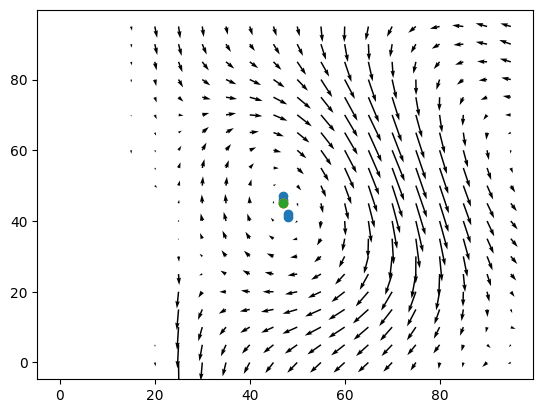

In [92]:
depth_lvl = 0
u, v = U[:,:,depth_lvl], V[:,:,depth_lvl]
a, b = 10, 4

x, y = np.arange(0, u.shape[0]), np.arange(0, u.shape[1])

eddy, eddy_uv, eddy_c = regs_nencioli(u, v, a, b)

print(eddy_c)

spacing = 5
plt.quiver(x[::spacing], y[::spacing], U[::spacing,::spacing,depth_lvl].T,V[::spacing,::spacing,depth_lvl].T)
plt.scatter(eddy_uv.i, eddy_uv.j)
plt.scatter(eddy_c.i, eddy_c.j)
plt.scatter(eddy.i, eddy.j)